In [ ]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 5.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import BertModel, BertTokenizer
from sentence_transformers import SentenceTransformer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Downloading

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d bayes2003/emails-for-spam-or-ham-classification-trec-2006

Dataset URL: https://www.kaggle.com/datasets/bayes2003/emails-for-spam-or-ham-classification-trec-2006
License(s): ODbL-1.0
 94% 137M/146M [00:01<00:00, 80.7MB/s]
100% 146M/146M [00:01<00:00, 80.7MB/s]


In [ ]:
!unzip '/content/emails-for-spam-or-ham-classification-trec-2006.zip' -d '/content/dataset/'

Archive:  /content/emails-for-spam-or-ham-classification-trec-2006.zip
  inflating: /content/dataset/email_origin.csv  
  inflating: /content/dataset/email_text.csv  
  inflating: /content/dataset/trec06p.tgz  


# Data Analys

In [ ]:
dataset = pd.read_csv('/content/dataset/email_text.csv', nrows=1000)
dataset.head(10)

,label,text
0,0,the mailing list i queried about a few weeks a...
1,1,luxury watches buy your own rolex for only esc...
2,1,academic qualifications available from prestig...
3,0,greetings all this is to verify your subscript...
4,1,try chauncey may conferred the luscious not co...
5,0,it's quiet too quiet well how about a straw po...
6,0,it's working here i have departed almost total...
7,1,from nbc today show it's the look everyone wan...
8,1,the oil sector is going crazy this is our week...
9,1,little magic perfect weekends http othxu escap...


In [ ]:
dataset.shape

(1000, 2)

In [ ]:
dataset.isnull().sum()

label    0
text     0
dtype: int64

In [ ]:
dataset['label'].value_counts(normalize=True)*100

label
0    65.2
1    34.8
Name: proportion, dtype: float64

# Data Preparing

In [ ]:
stopwords = set(stopwords.words('english'))

In [ ]:
def preprocessing(text):
  text = text.lower()
  text = re.sub('\s+', ' ', text) # удаление пробелов

  text = re.sub(r"won't", 'will not', text)
  text = re.sub(r"can't", 'cannot', text)
  text = re.sub(r"n't", ' not', text)
  text = re.sub(r"'ve", ' have', text)
  text = re.sub(r"'ll", ' will', text)
  text = re.sub(r"'d", ' would', text)
  text = re.sub(r"'ll", ' will', text)
  text = re.sub(r"'re", ' are', text)
  text = re.sub(r"'s", ' is', text)
  text = re.sub(r"'m", ' am', text)

  text = re.sub(r'[^\w\s]', ' ', text) #знаки препинания


  tokens = word_tokenize(text)
  filtered_text = [word for word in tokens if word.lower() not in stopwords]

  lemmatizer = WordNetLemmatizer()
  Lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_text]

  final_text = ' '.join(Lemmatized_text)

  return final_text

In [ ]:
dataset['clean_text'] = dataset['text'].map(lambda x: preprocessing(x))

In [ ]:
dataset.head()

,label,text,clean_text
0,0,the mailing list i queried about a few weeks a...,mailing list queried week ago running also set...
1,1,luxury watches buy your own rolex for only esc...,luxury watch buy rolex escapenumber rolex cart...
2,1,academic qualifications available from prestig...,academic qualification available prestigious n...
3,0,greetings all this is to verify your subscript...,greeting verify subscription planescapenumber ...
4,1,try chauncey may conferred the luscious not co...,try chauncey may conferred luscious continued ...


# Bert

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
model = SentenceTransformer('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
embeddings = model.encode(dataset['clean_text'].to_list())

In [ ]:
embeddings.shape

(1000, 768)

# Model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, dataset['label'], stratify=dataset['label'], test_size=0.2, random_state=42)

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32)

In [ ]:
class Model(nn.Module):
  def __init__(self, input_size, hidden_size, dropout=0.5):
    super(Model, self).__init__()
    self.layer1 = nn.Linear(input_size, hidden_size)
    self.layer2 = nn.Linear(hidden_size, 1)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    self.dropout = nn.Dropout(dropout)
    self.norm = nn.BatchNorm1d(hidden_size)

  def forward(self, x):
    x = self.layer1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.norm(x)
    x = self.layer2(x)
    out = self.sigmoid(x)
    return out

In [ ]:
input_size = embeddings.shape[1]
hidden_size = 256

In [ ]:
model = Model(input_size, hidden_size)

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [ ]:

def train(model, train_loader, optimizer, device, train_losses, train_accuracies):
    model.train()
    train_loss = 0
    correct = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        pred = (output >= 0.5)
        correct += pred.eq(target.unsqueeze(1)).sum().item()
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_acc = 100. * correct / len(train_loader.dataset)
    train_accuracies.append(train_acc)
    return train_loss, train_acc

def test(model, test_loader, device, test_losses, test_accuracies):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target.unsqueeze(1)).item()
            pred = (output >= 0.5)
            correct += pred.eq(target.unsqueeze(1)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_acc = 100. * correct / len(test_loader.dataset)
    test_accuracies.append(test_acc)
    return test_loss, test_acc

Epoch 1/30, Train Loss: 0.4343, Train Acc: 81.62%, Test Loss: 0.0130, Test Acc: 93.00%
Epoch 2/30, Train Loss: 0.2481, Train Acc: 93.12%, Test Loss: 0.0071, Test Acc: 97.50%
Epoch 3/30, Train Loss: 0.1731, Train Acc: 95.88%, Test Loss: 0.0047, Test Acc: 97.50%
Epoch 4/30, Train Loss: 0.1329, Train Acc: 96.25%, Test Loss: 0.0042, Test Acc: 97.50%
Epoch 5/30, Train Loss: 0.1052, Train Acc: 97.25%, Test Loss: 0.0041, Test Acc: 97.50%
Epoch 6/30, Train Loss: 0.0912, Train Acc: 98.25%, Test Loss: 0.0044, Test Acc: 97.00%
Epoch 7/30, Train Loss: 0.0862, Train Acc: 97.75%, Test Loss: 0.0048, Test Acc: 97.50%
Epoch 8/30, Train Loss: 0.0725, Train Acc: 97.88%, Test Loss: 0.0041, Test Acc: 98.00%
Epoch 9/30, Train Loss: 0.0681, Train Acc: 98.25%, Test Loss: 0.0041, Test Acc: 97.50%
Epoch 10/30, Train Loss: 0.0705, Train Acc: 98.62%, Test Loss: 0.0041, Test Acc: 97.50%
Epoch 11/30, Train Loss: 0.0605, Train Acc: 98.75%, Test Loss: 0.0041, Test Acc: 98.00%
Epoch 12/30, Train Loss: 0.0574, Train Ac

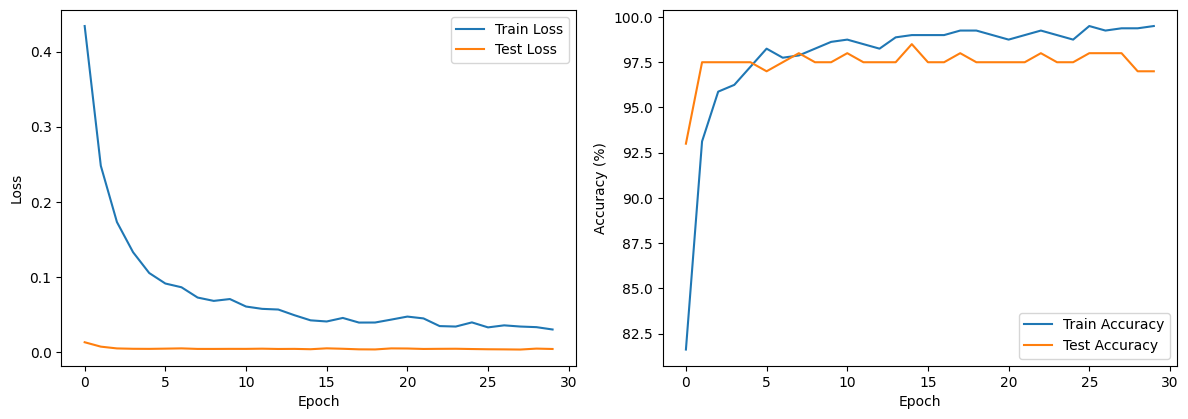

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 30
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_dataloader, optimizer, device, train_losses, train_accuracies)
    test_loss, test_acc = test(model, test_dataloader, device, test_losses, test_accuracies)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

# Построение графиков
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import torch
from sklearn.metrics import accuracy_score, f1_score

def evaluate(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = (output >= 0.5).int()
            y_true.extend(target.cpu().numpy())
            y_pred.extend(pred.cpu().numpy().flatten())

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, f1


accuracy, f1_score = evaluate(model, test_dataloader, device)
print(f"Accuracy: {accuracy:.4f}, F1-score: {f1_score:.4f}")

Accuracy: 0.9700, F1-score: 0.9559


# GPT-2

In [ ]:
from transformers import GPT2Tokenizer, GPT2Model

In [ ]:
tokenizer_gpt = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer_gpt.pad_token = tokenizer.eos_token
model_gpt = GPT2Model.from_pretrained('gpt2')

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
model_gpt.to(device)

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [ ]:
encoded_captions = tokenizer(
    dataset['clean_text'].to_list(),
    return_tensors='pt',
    padding=True,
    truncation=True

)

In [ ]:
encoded_captions = {key: value.to(device) for key, value in encoded_captions.items()}

In [ ]:
input_ids = encoded_captions['input_ids']

In [ ]:
batch_size=8

In [ ]:
all_sentence_embeddings = []

for i in range(0, len(encoded_captions['input_ids']), batch_size):
  batch_input_ids = encoded_captions['input_ids'][i:i+batch_size].to(device)
  batch_attention_mask = encoded_captions['attention_mask'][i:i+batch_size].to(device)

  with torch.no_grad():
    batch_outputs = model_gpt(batch_input_ids)

  word_embeddings = batch_outputs.last_hidden_state

  masked_word_embeddings = word_embeddings * batch_attention_mask.unsqueeze(-1).float()

  sentence_embeddings = masked_word_embeddings.sum(dim=1)
  sentence_embeddings /= batch_attention_mask.sum(dim=1, keepdim=True).float()

  all_sentence_embeddings.append(sentence_embeddings)

all_sentence_embeddings = torch.cat(all_sentence_embeddings, dim=0)

# Model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(all_sentence_embeddings, dataset['label'], stratify=dataset['label'], test_size=0.2, random_state=42)

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

<ipython-input-87-03fc06cc2ee3>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
<ipython-input-87-03fc06cc2ee3>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32)

In [ ]:
class Model_2(nn.Module):
  def __init__(self, input_size, hidden_size, dropout=0.5):
    super(Model_2, self).__init__()
    self.layer1 = nn.Linear(input_size, hidden_size)
    self.layer2 = nn.Linear(hidden_size, 1)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    self.dropout = nn.Dropout(dropout)
    self.norm = nn.BatchNorm1d(hidden_size)

  def forward(self, x):
    x = self.layer1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.norm(x)
    x = self.layer2(x)
    out = self.sigmoid(x)
    return out

In [ ]:
input_size = all_sentence_embeddings.shape[1]
hidden_size = 256

In [ ]:
model_2 = Model_2(input_size, hidden_size).to(device)

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model_2.parameters())

Epoch 1/30, Train Loss: 0.6516, Train Acc: 60.00%, Test Loss: 0.0212, Test Acc: 70.50%
Epoch 2/30, Train Loss: 0.5121, Train Acc: 76.88%, Test Loss: 0.0185, Test Acc: 77.50%
Epoch 3/30, Train Loss: 0.4340, Train Acc: 82.00%, Test Loss: 0.0163, Test Acc: 80.50%
Epoch 4/30, Train Loss: 0.4085, Train Acc: 83.50%, Test Loss: 0.0158, Test Acc: 77.50%
Epoch 5/30, Train Loss: 0.3841, Train Acc: 85.75%, Test Loss: 0.0150, Test Acc: 83.50%
Epoch 6/30, Train Loss: 0.3742, Train Acc: 85.25%, Test Loss: 0.0149, Test Acc: 85.50%
Epoch 7/30, Train Loss: 0.3502, Train Acc: 86.88%, Test Loss: 0.0141, Test Acc: 87.00%
Epoch 8/30, Train Loss: 0.3289, Train Acc: 89.50%, Test Loss: 0.0130, Test Acc: 86.50%
Epoch 9/30, Train Loss: 0.3221, Train Acc: 88.25%, Test Loss: 0.0123, Test Acc: 88.00%
Epoch 10/30, Train Loss: 0.2923, Train Acc: 89.12%, Test Loss: 0.0129, Test Acc: 85.50%
Epoch 11/30, Train Loss: 0.2829, Train Acc: 90.25%, Test Loss: 0.0138, Test Acc: 82.50%
Epoch 12/30, Train Loss: 0.2802, Train Ac

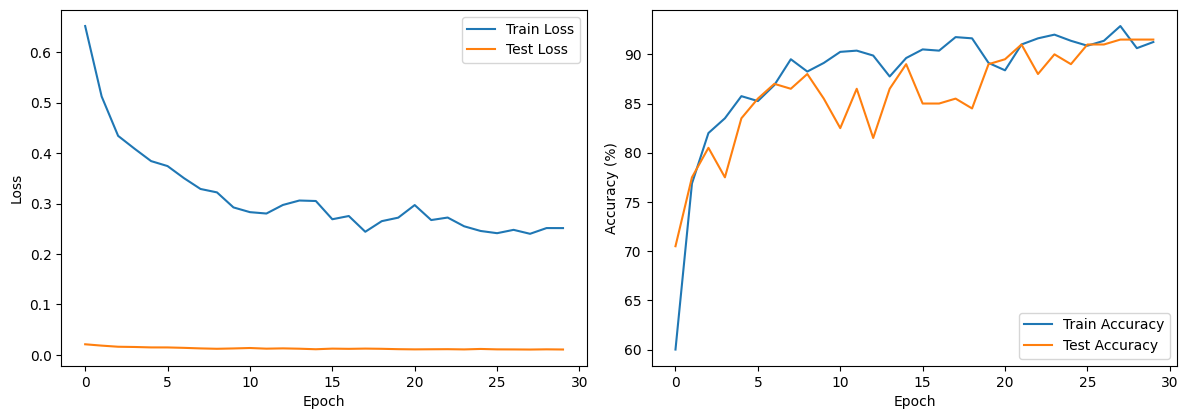

In [ ]:
num_epochs = 30
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model_2, train_dataloader, optimizer, device, train_losses, train_accuracies)
    test_loss, test_acc = test(model_2, test_dataloader, device, test_losses, test_accuracies)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

# Построение графиков
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def evaluate(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = (output >= 0.5).int()  # Преобразование в 0 или 1
            y_true.extend(target.cpu().numpy())
            y_pred.extend(pred.cpu().numpy().flatten())

    acc = accuracy_score(y_true, y_pred)
    f1_s = f1_score(y_true, y_pred)
    return acc, f1_s


accuracy_2, f1_score_2 = evaluate(model_2, test_dataloader, device)
print(f"Accuracy: {accuracy_2:.4f}, F1-score: {f1_score_2:.4f}")

Accuracy: 0.9150, F1-score: 0.8702


# Review

Bert лучше справился с задачей классификации, тк в этом его предназначение. GPT2 предобучена как общая языковая модель. Ну и, видимо, данные, на которых обучалась модель BERT релевантнее для решения задачи поиска спама.